# Averaged Artifact Substraction with EEG Data
## First step prepare Jupyter Notebook

In [1]:
import os
import sys
import mne
from facet.facet import facet
from loguru import logger
from mne.annotations import Annotations
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../src")
from facet.Epilepsy.template_utils import annotate_spike, extract_template, find_spike_template, extract_median_spike, backproject_ic_to_sensor, plot_top_matches_from_results
from facet.Epilepsy.template_utils import detect_spike_matches, plot_match_with_template, basic_clean, compute_adaptive_threshold, scale_eeg_to
import scipy.stats as st
from scipy.signal import find_peaks

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

f = facet()

2025-06-12 00:07:25.719 | ERROR    | facet.helpers.fastranc:<module>:23 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll does not exist. Run the build.py script to create the file.
2025-06-12 00:07:25.720 | ERROR    | facet.helpers.fastranc:<module>:40 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll could not be opened! Check your Project Files Message: Could not find module 'c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers\fastranc.dll' (or one of its dependencies). Try using the full path with constructor syntax.
2025-06-12 00:07:25.721 | INFO     | facet.helpers.fastranc:<module>:41 - Current working directory: g:\Medical Engineering and Analytics\Project\FACETpy\examples\epilepsynotebooks


## Second Step import EEG Data and process

2025-06-12 00:07:29.970 | INFO     | facet.facet:import_eeg:33 - Importing EEG from ../datasets/chb01_03.edf


Unknown or mismatched units:  → uv. No scaling.
Adaptive reject threshold ≈ 1796.3 µV


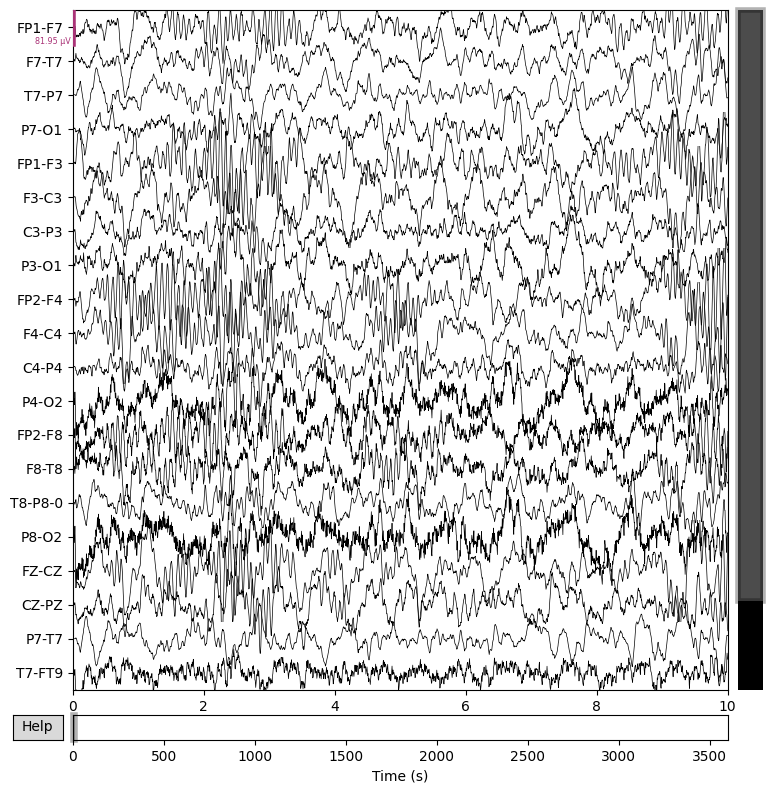

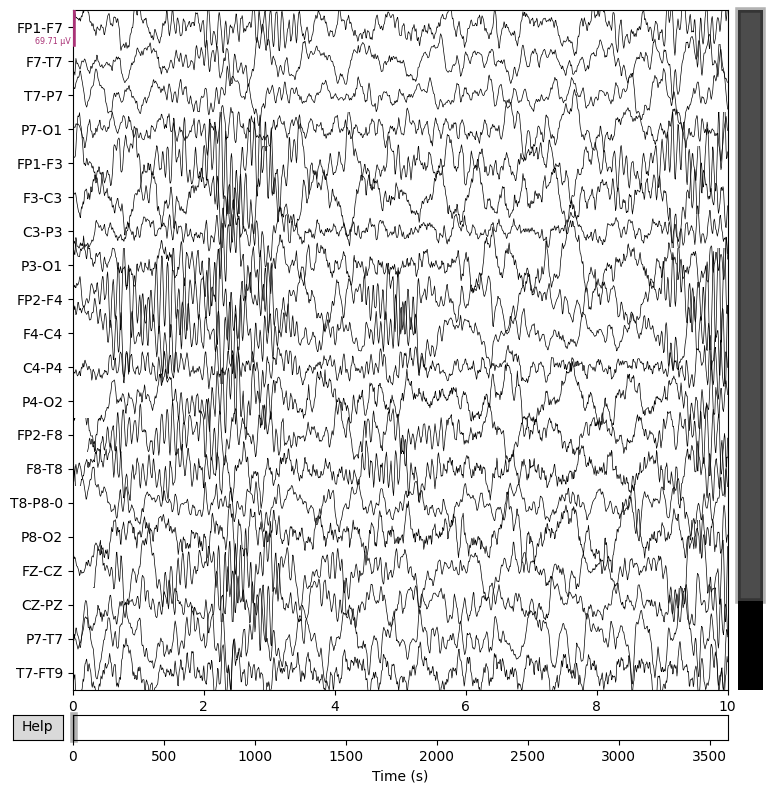

In [2]:
# Step 1 — Import EEG with FACET
eegDataSet = "../datasets/chb01_03.edf"
f.import_eeg(eegDataSet, artifact_to_trigger_offset=-0.005, bads=["EMG", "ECG"])
raw = f.get_eeg().mne_raw


raw = scale_eeg_to(raw, target="uV") #convert from volts (as often in CHB-MIT) to microvolts (µV)
raw.set_montage('standard_1020', on_missing='warn')
    

# quick robust estimate of channel peak-to-peak
thr = compute_adaptive_threshold(raw)
print(f"Adaptive reject threshold ≈ {thr:.1f} µV")


# band-pass, notch, crop and ICA – all in one helper
raw_clean, ica = basic_clean(
        raw,
        l_freq    = 1. ,
        h_freq    = 40.,
        notch     = 50 ,
        crop_tmin = 10,     # skip first 10 s
        crop_tmax = 180,    # analyse up to 180 s
        ica_var   = 0.99,
        reject_uV = thr
)

raw.plot(start=0, duration=10, scalings='auto')
raw_clean.plot(start=0, duration=10, scalings='auto')


plt.close("all")


### Plot the seizure part

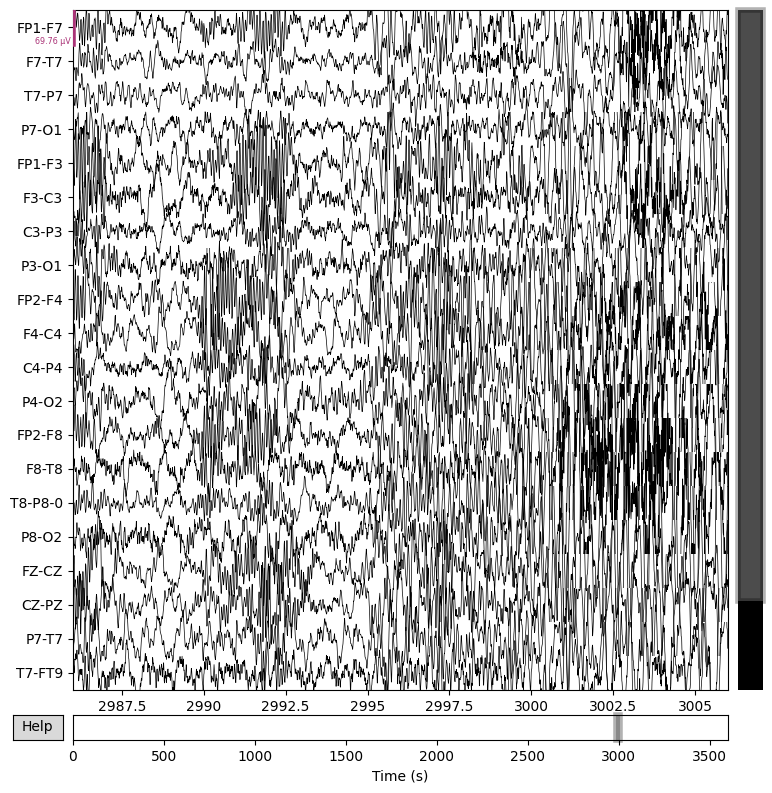

In [3]:

# Define seizure start/end (from the note)
seizure_start = 2996
seizure_end = 3036

# Plot 20 seconds around the start
raw_clean.plot(start=seizure_start - 10, duration=20, scalings='auto', title="Seizure Onset (Cleaned Data)")
plt.close("all")

### Zoom in

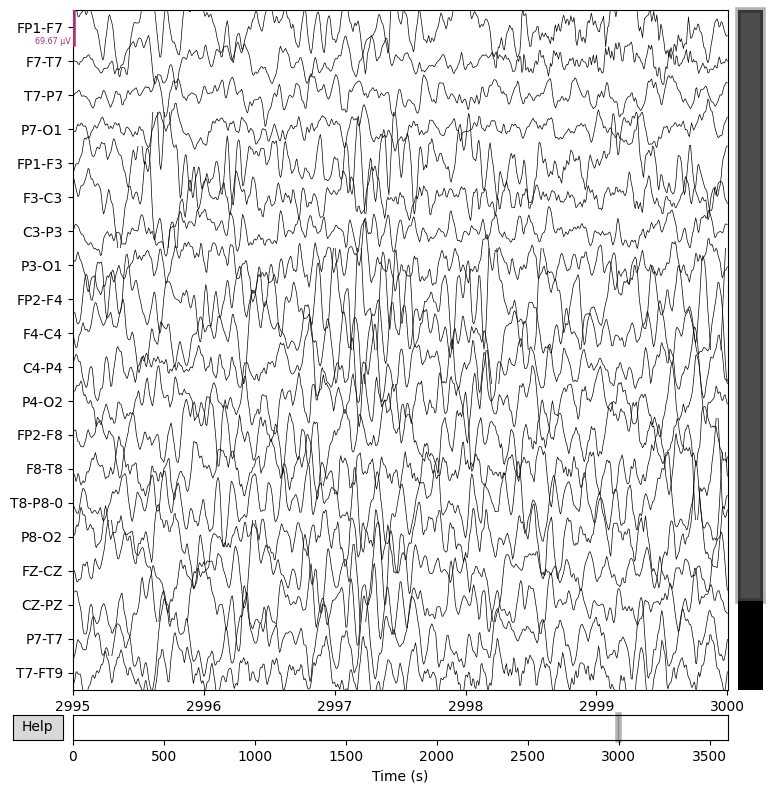

In [4]:
raw_clean.plot(start=2995, duration=5, scalings='auto', title="Zoom on Seizure Onset")
plt.close("all")

### Plot a tight window 
Zoom in around 2996–2997s since the seizure starts at 2996 seconds

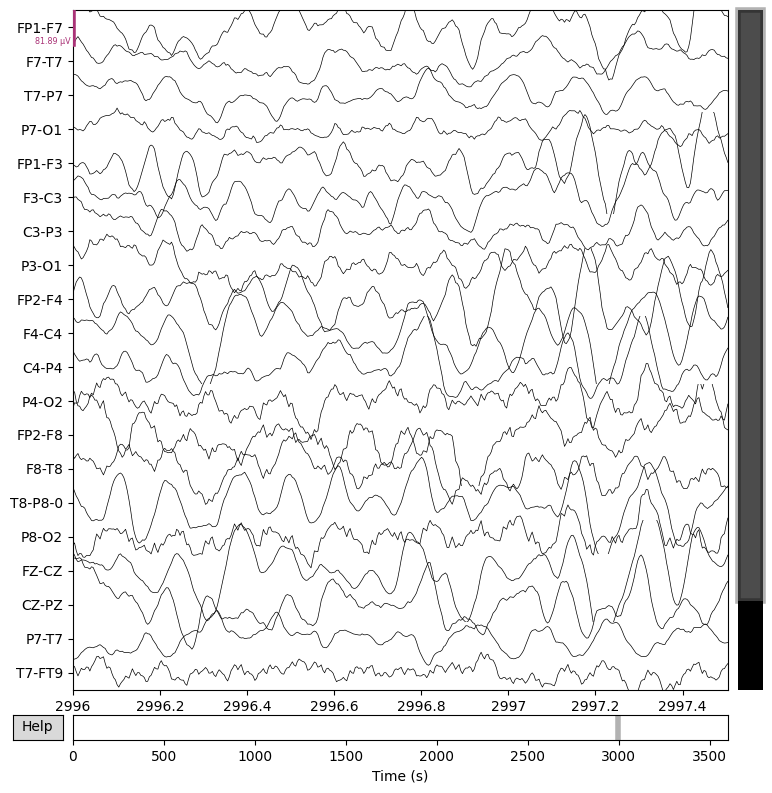

In [5]:
raw.plot(start=2996, duration=1.5, scalings='auto')
plt.close("all")

## Plot T8-P8-0 near seizure start

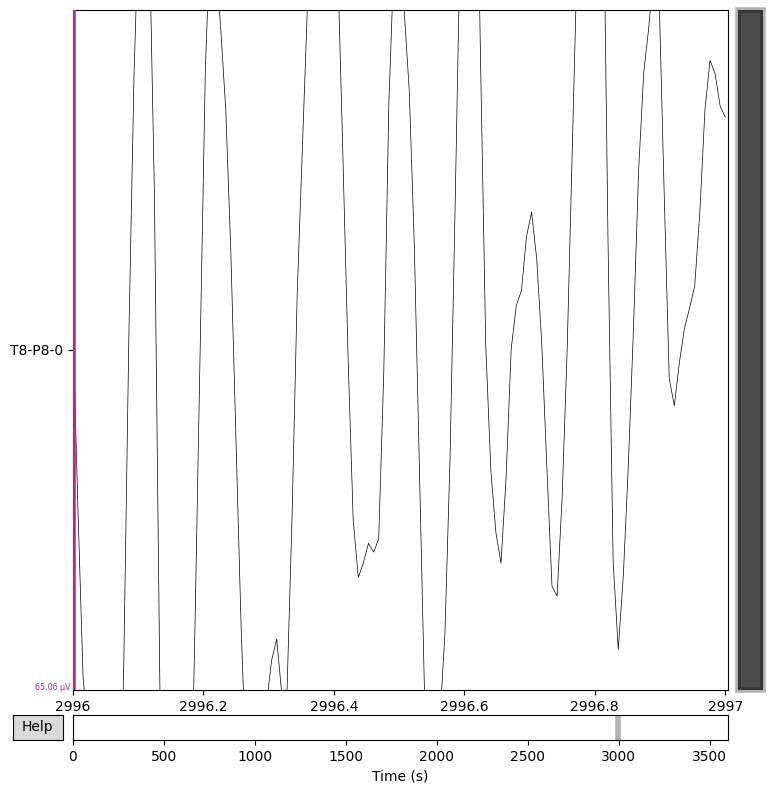

In [6]:
raw_temp = raw_clean.copy().pick(["T8-P8-0"])
raw_temp.plot(start=2996, duration=1.0, scalings='auto')
plt.close("all")

### Manual Extraction (around 1996.6s)

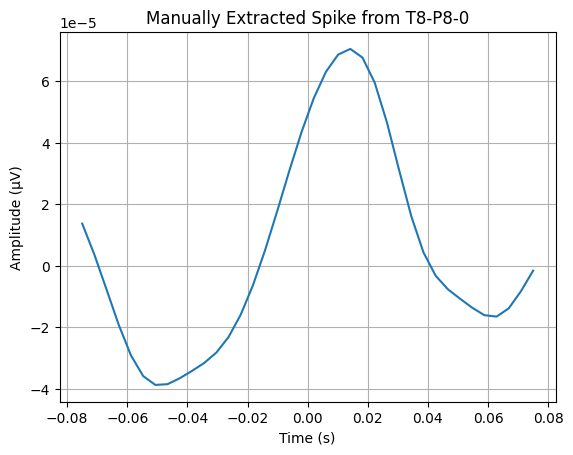

In [7]:


# Pick just the relevant channel
sig = raw_temp.copy().get_data()[0]
sfreq = raw_temp.info["sfreq"]

# Set the center time of the spike and the window around it
center_time = 2996.6  # in seconds
win = 0.15            # 150 ms window
half_win_samples = int(sfreq * win / 2)

# Convert center time to sample index
center_idx = int(center_time * sfreq)
start = center_idx - half_win_samples
end = center_idx + half_win_samples

# Extract the snippet
snippet = sig[start:end]
times = np.linspace(-win/2, win/2, len(snippet))

# Normalize the snippet to create a spike template
template = snippet - np.mean(snippet)
template /= np.std(template)

# Plot
plt.plot(times, snippet)
plt.title("Manually Extracted Spike from T8-P8-0")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()

### Cross Correlation through channels

FP2-F4: 638 matches
F4-C4: 569 matches
P7-T7: 569 matches
FP1-F3: 568 matches
CZ-PZ: 552 matches
FZ-CZ: 527 matches
FP2-F8: 520 matches
F7-T7: 502 matches
T8-P8-0: 500 matches
T8-P8-1: 500 matches
P4-O2: 469 matches
T7-P7: 459 matches
FP1-F7: 457 matches
P3-O1: 428 matches
C3-P3: 422 matches
C4-P4: 417 matches
P7-O1: 402 matches
F3-C3: 385 matches
P8-O2: 313 matches
FT10-T8: 310 matches
F8-T8: 270 matches
T7-FT9: 247 matches
FT9-FT10: 192 matches

Best match: FP2-F4 at 1346.40s (score = 0.99)


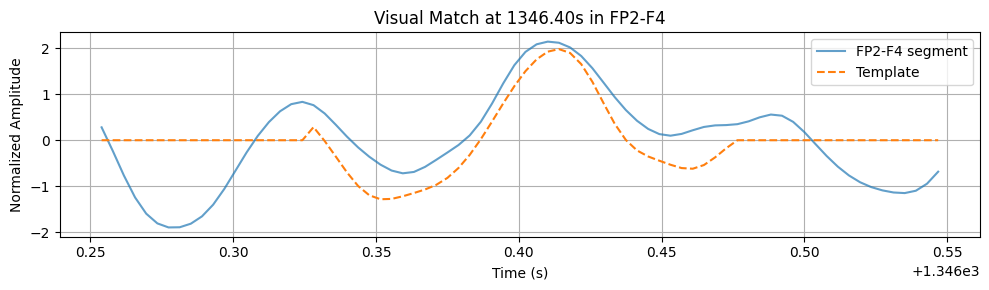

In [8]:
channel_scores = {}
top_score = -np.inf
top_channel = None
top_time = None
all_matches = {}
# Loop through all EEG channels
for ch in raw_clean.info["ch_names"]:
    match_times, match_scores = detect_spike_matches(
        raw_clean, ch, template,
        threshold_ratio=0.8,     # Adjust if needed
        normalize=True,
    )
    channel_scores[ch] = len(match_times)
    all_matches[ch] = (match_times, match_scores)


    if match_scores:  # Update best match
        max_idx = np.argmax(match_scores)
        if match_scores[max_idx] > top_score:
            top_score = match_scores[max_idx]
            top_channel = ch
            top_time = match_times[max_idx]

# Show summary
sorted_channels = sorted(channel_scores.items(), key=lambda x: x[1], reverse=True)
for ch, count in sorted_channels:
    print(f"{ch}: {count} matches")

if top_time is not None:
    print(f"\nBest match: {top_channel} at {top_time:.2f}s (score = {top_score:.2f})")
    plot_match_with_template(raw_clean, top_channel, [top_time], template, raw_clean.info["sfreq"])
else:
    print("\nNo matches passed the threshold.")


Top 3 matches in T8-P8-0:
T8-P8-0 at 961.36s (score = 0.97)


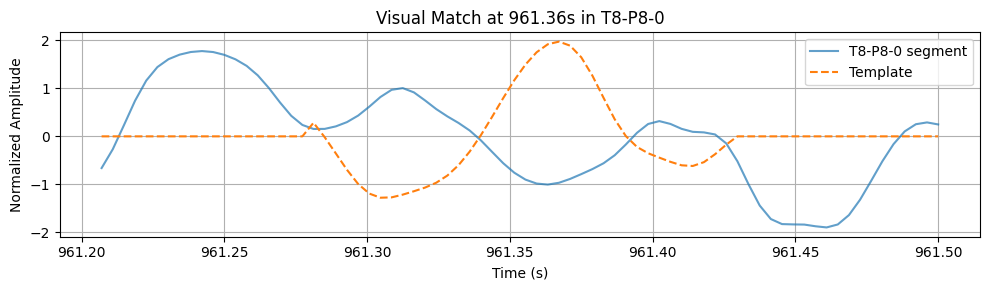

T8-P8-0 at 455.48s (score = 0.96)


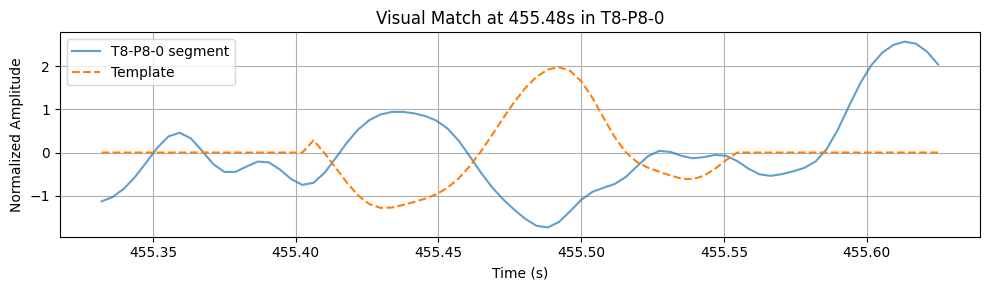

T8-P8-0 at 614.31s (score = 0.96)


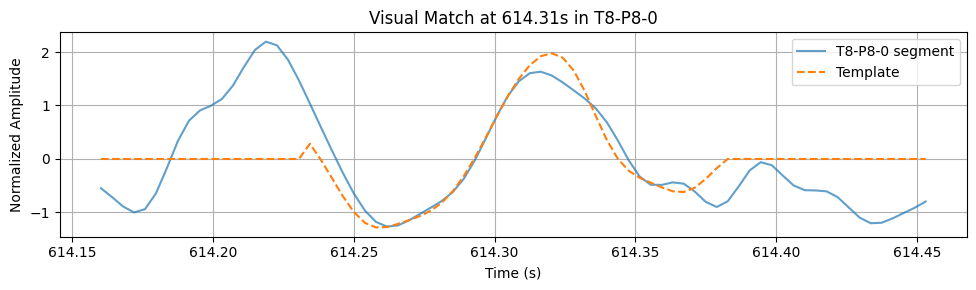

In [12]:
ch = "T8-P8-0"
match_times, match_scores = all_matches.get(ch, ([], []))
plot_top_matches_from_results(raw_clean, ch, match_times, match_scores, template, top_n=3)


### Find score closest to 2996.5


In [13]:
match_times, match_scores = detect_spike_matches(
    raw_clean, "T8-P8-0", template,
    threshold_ratio=0.0,  # No cutoff
    normalize=True
)

# Find match closest to ~2996.5
closest_idx = np.argmin(np.abs(np.array(match_times) - 2996.5))
print(f"T8-P8-0 near 2996.5s: score = {match_scores[closest_idx]:.2f}")


T8-P8-0 near 2996.5s: score = 0.87
